In [1]:
import vipy.dataset.meva

In [2]:
meva = vipy.dataset.meva.KF1(videodir='/Volumes/JEBYRNE/meva/Mevadata_Public_01', 
                             repodir='/Volumes/JEBYRNE/meva/meva-data-repo',
                             disjoint=True,  # Force causal activities (open/close) to be disjoint
                             unpad=True,     # Remove arbitrary temporal padding
                             merge=True,     # Merge activities with track correspondence
                             n_videos=1)     # take subset
                             

[vipy.dataset.meva.KF1]: Loading 1 YAML files
[vipy.dataset.meva.KF1]: Parsing "/Volumes/JEBYRNE/meva/meva-data-repo/annotation/DIVA-phase-2/MEVA/kitware/2018-03-07/17/2018-03-07.16-55-00.17-00-00.admin.G329.activities.yml"
[vipy.dataset.meva.KF1]: merging videos ...
[vipy.video.union]: merging track "<vipy.object.track: category="person", startframe=2064, endframe=2311, keyframes=248>" -> "<vipy.object.track: category="person", startframe=2047, endframe=2076, keyframes=30>" for scene "<vipy.video.scene: filename="/Volumes/JEBYRNE/meva/Mevadata_Public_01/drop-01/2018-03-07/17/2018-03-07.16-55-00.17-00-00.admin.G329.avi", fps=30.0, objects=15, activities=9>"
[vipy.video.union]: merging track "<vipy.object.track: category="person", startframe=4656, endframe=4894, keyframes=239>" -> "<vipy.object.track: category="person", startframe=4869, endframe=4940, keyframes=72>" for scene "<vipy.video.scene: filename="/Volumes/JEBYRNE/meva/Mevadata_Public_01/drop-01/2018-03-07/17/2018-03-07.16-55-00

In [3]:
# All annotated videos in MEVA dataset
V = meva.videos()  

# All trimmed activity clips in the first video
A = V[0].activityclip()

# Here is an activity clip that has multiple overlapping activity categories per frame (opening and exiting)
a = A[-2]
print(a)

<vipy.video.scene: filename="/Volumes/JEBYRNE/meva/Mevadata_Public_01/drop-01/2018-03-07/17/2018-03-07.16-55-00.17-00-00.admin.G329.avi", fps=30.0, clip=(7910,7964), category="person_opens_facility_door", objects=1, activities=2>


In [4]:
# Generate resized randomcrop torch tensors and framewise multi-label ground truth categories for training
# This generates a cropped square cuboid, from the union of all boxes in this activity
(tensor, multilabel) = (a.activitycuboid(dilate=1.2, maxdim=256).randomcrop( (224,224) ).normalize(mean=(0,0,0), std=(1,1,1)).torch(startframe=0, length=50, boundary='repeat'),
                        a.activitylabels(startframe=0, endframe=50))
                             
# This (tensor, multilabel) tuple can be used for training with a multi-label loss (e.g. BCE)
print(tensor.shape)
print(multilabel)

torch.Size([50, 3, 224, 224])
[{'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_opens_facility_door'}, {'person_

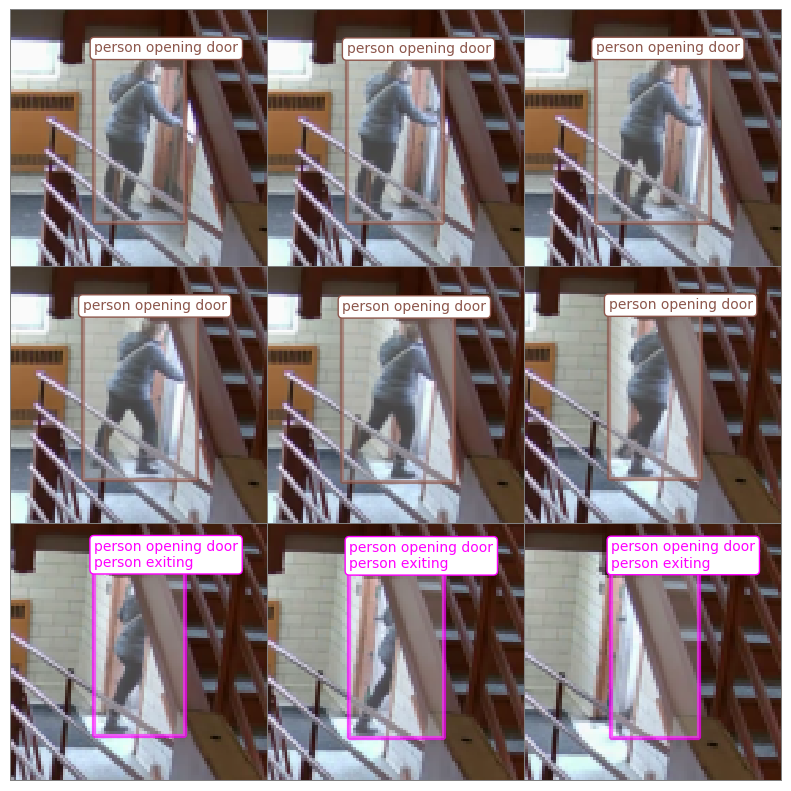

<vipy.image: height=772, width=772, color=rgb>

In [5]:
# Visualize this activity using a "quicklook" style framewise montage
a.quicklook().show()

In [6]:
# We strongly recommend that you cache the resized clips of each activity on a fast local drive prior to training.
# You can then take random crops and clips from these cached videos.  This will significantly speed up training, 
# since it does not require seeking through the original high-res videos

import os
from vipy.util import filetail
from vipy.batch import Batch

# parallel video processing
B = Batch([a for v in V for a in v.activityclip()], n_processes=2)  
A = B.map(lambda a: a.activitycuboid(dilate=1.2, maxdim=256)
                     .saveas(os.path.join('/tmp', a.category(), filetail(a.filename())), flush=True)).result()
                        
print(A[0])

<vipy.video.scene: filename="/tmp/person_enters_scene_through_structure/2018-03-07.16-55-00.17-00-00.admin.G329.avi", fps=30.0, category="person_enters_scene_through_structure", objects=1, activities=1>
